This notebook imports the preprocessed musiccaps data and trains a CNN with the data.

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import cv2
import json
import librosa
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

2024-04-15 11:50:53.655980: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 11:50:53.697348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:50:54.368401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The 'filtered_meta_df.csv' file has been created in the '/home/mendu/Thesis/CNN_musiccaps_descriptive_analysis.ipynb' file

In [2]:
filtered_df = pd.read_csv('/home/mendu/Thesis/data/musiccaps/filtered_meta_df.csv', index_col=[0])

In [3]:
df = filtered_df.copy()

In [4]:
filtered_df.aspect_list.value_counts()

aspect_list
instrumental    730
pop             295
rock            251
classical       248
electronic      239
folk            195
hip hop         122
jazz             72
country          60
r&b              57
metal            50
Name: count, dtype: int64

In [5]:
'''Undersampling instrumental label'''
# Number of rows to drop for the 'instrumental' class
rows_to_drop = 400

# Identify the rows corresponding to the 'instrumental' class
instrumental_rows = filtered_df[filtered_df['aspect_list'] == 'instrumental']

# Randomly sample rows from the 'instrumental' class to drop
instrumental_to_drop = instrumental_rows.sample(n=rows_to_drop, random_state=42)

# Drop the sampled rows from the DataFrame to undersample
filtered_df = filtered_df.drop(instrumental_to_drop.index)

In [6]:
filtered_df.aspect_list.value_counts()


aspect_list
instrumental    330
pop             295
rock            251
classical       248
electronic      239
folk            195
hip hop         122
jazz             72
country          60
r&b              57
metal            50
Name: count, dtype: int64

# Training the model

In [5]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [6]:
'''loading the cropped .npy files in a tensor'''

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/musiccaps/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = filtered_df.fname.to_list()

data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename) + '.wav.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  
  # Check to ensure the image has the minimum required dimensions
  if img.shape[0] >= 128 and img.shape[1] >= 431:
    img = img[:128, :431]
    data.append(add_gauss_noise(img))
  else:
    print(f"Error with file: {filename_npy}. Expected minimum shape of (128, 431) but got {img.shape}.")
    # Handle the error properly, either skip this image or pad/crop it accordingly

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


[-0SdAVK79lg]-[30-40]
[-1LrH01Ei1w]-[30-40]
[-4NLarMj4xU]-[30-40]
[-5f6hjZf9Yw]-[30-40]
[-6QGvxvaTkI]-[280-290]
[-Dtir74TiUM]-[40-50]
[-FlvaZQOr2I]-[90-100]
[-JVWfFPBl84]-[330-340]
[-M-6VinyMiY]-[30-40]
[-O9mnfC61Ac]-[0-10]


In [7]:
#normalize data
data = data.astype('float32')/255.0

#shape of the tensor
data.shape

(2319, 128, 431)

In [8]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 431, 1))

# Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(filtered_df['aspect_list']), test_size=0.1, random_state=42)

# The code for splitting data if oversampling
X_train, X_val, y_train, y_val = train_test_split(data, filtered_df['aspect_list'], test_size=0.3, random_state=42)

In [9]:
'''To compute class weights'''
# # Compute class weights manually for one-hot encoded labels
# class_totals = y_train.sum(axis=0)
# total_samples = y_train.shape[0]
# class_weights = total_samples / (len(class_totals) * class_totals)

# # Convert class weights to a dictionary for easier use
# class_weight_dict = dict(enumerate(class_weights))

'To compute class weights'

In [10]:
'''Oversampling the minority class labels to have equal number of data instances in all of the classes'''

# Creating a temp df that has two rows mel_specs and the aspect_list
temp_train = pd.DataFrame(list(zip(X_train, y_train.tolist())), columns = ['mel_spec', 'aspect_list'])

class_counts = temp_train['aspect_list'].value_counts()
max_samples = class_counts.max()

# Resample the data to balance the classes
resampled_data = []
for class_name, count in class_counts.items():
    # Calculate the number of samples to add to balance the class distribution
    num_samples_to_add = max_samples - count
    
    # Resample the minority class (with replacement)
    minority_class_samples = temp_train[temp_train['aspect_list'] == class_name].sample(n=num_samples_to_add, replace=True, random_state=42)
    
    # Append the resampled minority class samples to the resampled data list
    resampled_data.append(minority_class_samples)

# Concatenate the resampled data to create the balanced dataset
balanced_df = pd.concat([temp_train] + resampled_data, ignore_index=True)

# Verify the class distribution in the balanced dataset
print(balanced_df['aspect_list'].value_counts())

aspect_list
instrumental    496
rock            496
metal           496
pop             496
folk            496
electronic      496
country         496
r&b             496
jazz            496
classical       496
hip hop         496
Name: count, dtype: int64


In [11]:
# Converting the X_train back into an array of mel-specs
X_train = np.stack(balanced_df['mel_spec'].tolist())

# Checking the shape of X_train
X_train.shape

#One hot encoding the y data
y_train = pd.get_dummies(balanced_df['aspect_list'])
y_val = pd.get_dummies(y_val)

when there is no weights, the weight for each class is one. AFter applying weights the values are inversely propotionate to the count. Try to find something between 1 and the latter.

Oversample after splitting into val and train; not before

In [12]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [13]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

11

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2

# l2 regularization
ltwo_reg = 0.01

# Initialize the model
model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=(128, 431, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# New convolutional layers
model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-15 11:51:35.273941: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 429, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 212, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 104, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 104, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 104, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 50, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 25, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 23, 512)     │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 23, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 23, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 11, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,441,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,014,699 (11.50 MB)

 Trainable params: 3,012,459 (11.49 MB)

 Non-trainable params: 2,240 (8.75 KB)

Make the model deeper

In [15]:
X_train.shape

(5456, 128, 431, 1)

In [16]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    # class_weight=class_weight_dict,
    callbacks=[early_stopper]
)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 65s 366ms/step - accuracy: 0.2721 - loss: 9.8675 - val_accuracy: 0.0259 - val_loss: 5.7196
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 363ms/step - accuracy: 0.4410 - loss: 3.7753 - val_accuracy: 0.0948 - val_loss: 4.1938
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 364ms/step - accuracy: 0.5678 - loss: 2.7988 - val_accuracy: 0.0991 - val_loss: 3.8907
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 364ms/step - accuracy: 0.6580 - loss: 2.5594 - val_accuracy: 0.1523 - val_loss: 3.8875
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 364ms/step - accuracy: 0.7093 - loss: 2.4839 - val_accuracy: 0.2658 - val_loss: 3.8878
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 63s 365ms/step - accuracy: 0.7588 - loss: 2.5121 - val_accuracy: 0.1121 - val_loss: 6.9892
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.7491 - loss: 2.6018 - val_accuracy: 0.2241 - val_loss: 4.7477
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 364ms/step - accuracy: 0.7779 -

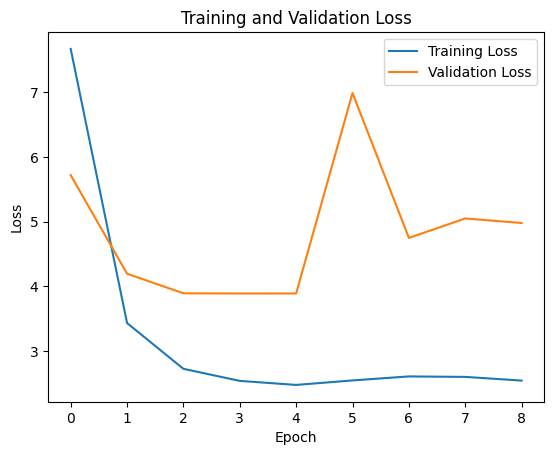

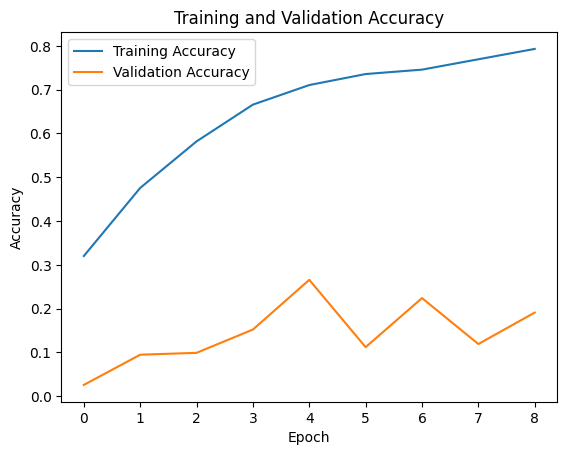

In [17]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
y_val

,classical,country,electronic,folk,hip hop,instrumental,jazz,metal,pop,r&b,rock
1125,False,False,False,False,False,False,False,False,True,False,False
548,False,True,False,False,False,False,False,False,False,False,False
100,False,False,False,False,False,False,False,False,True,False,False
838,False,False,False,False,False,True,False,False,False,False,False
251,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
534,False,False,False,False,False,False,False,False,True,False,False
30,True,False,False,False,False,False,False,False,False,False,False
1915,True,False,False,False,False,False,False,False,False,False,False
2311,False,False,False,False,False,True,False,False,False,False,False


In [19]:
class_labels = ['classical', 'country', 'electronic', 'folk', 'hip hop', 
               'instrumental', 'jazz', 'metal', 'pop', 'r&b', 'rock']

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Creating a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [23]:
comparison_table.Predicted.value_counts()

Predicted
rock            403
electronic      125
r&b              60
pop              44
jazz             28
metal            25
instrumental      9
hip hop           1
classical         1
Name: count, dtype: int64

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

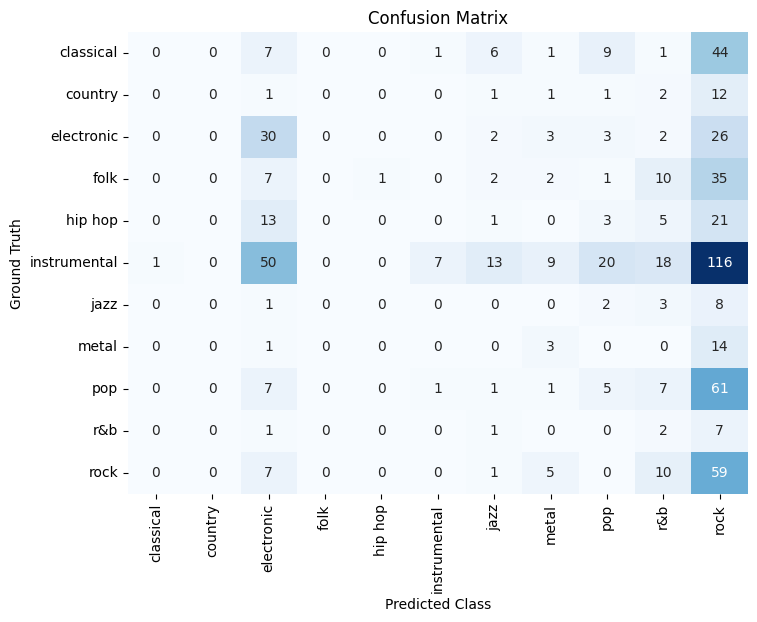

In [22]:
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()